<a href="https://colab.research.google.com/github/silviapiran/ETworkshop2024/blob/main/Kilonova_toy_model_SP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Kilonova Toy model

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [ ]:
#constants

M_SUN = 1.989e33 # cgs
C_CONST = 2.99792458e10 #cgs
SB_CONST = 5.670374419e-5 # Stefan-Boltzmann constant in cgs
H_CONST =  6.626176e-27 # Planck constant in cgs
KB_CONST = 1.380658e-16 # Boltzmann constant in cgs

UNIT_E = 0.5*1.e2*M_SUN*(C_CONST*1.e-2)**2 # more or less 1e47 erg
UNIT_R = 1e7 #100 km expressed in seconds
UNIT_TIME = UNIT_R/C_CONST

MPC = 3.08e24 #megaparsec in cm
tday = 86400.0

In [ ]:
# basic functions

#---------- Mass distribution -----------

def mass_distribution(v, v0, M, delta):

    #This function returns the total mass above a given velocity.
    #It is modelled by a power-law with index delta

    mass_higher = np.where(v>=v0, M*((v/v0)**(-delta)), 0.0)

    return mass_higher


#-------- The model -----------

# function that returns dy/dt
def model(t,Eth, v, R0, Mv, dMv, Mn, Ye):

    # This function returns the time derivative of the thermal energy
    # within a given mass layer.


    Rv = radius(R0, v, t) #radius evolution
    kv = opacity(Ye)

    ad_cool = adiabatic_cooling(Eth, v, Rv)
    lum_v = luminosity(Eth, t, v, R0, kv, Mv) #calculate radiative loss

    q_v = heating(t, Mv, dMv, Mn, Ye)

    dydt = - ad_cool - lum_v + q_v
    return dydt


# ----------- Function needed by the models -----------

def radius(R0, v, t):

    #This function returns the radius of a given mass layer with
    #velocity v at the time t

    return R0 + v*t

def adiabatic_cooling(Eth, v, R):

    # This function returns the contribution of the adiabatic cooling (pdV work)
    # in the energy conservation equation

    ad_cool = Eth*v/R


    return ad_cool


def luminosity(Eth, t, v, R0, kv, Mv):

    # This function returns the radiative loss in the energy conservation
    # equation


    Rv = radius(R0, v, t)

    t_lc = Rv/C_CONST #light crossing time
    form_factor = 3
    t_dv = 3*Mv*kv/(4*np.pi*Rv*C_CONST*form_factor)
    luminosity = Eth/(t_dv + t_lc)

    return luminosity


def heating(t, Mv, dMv, Mn, Ye):

    # This function returns the heating (from different sources) in the energy
    # conservation equation




    Xr, qrn = heating_free_neutrons(t, dMv, Mv, Mn, Ye)
    q_r = heating_rprocess(t, dMv, Xr)

    # Parameters for a magnetar central engine

    B = 0.0        # magnetic field at the surface (Gauss units, set to <= 0 to set the magnetar off)
    P0 = 4.e-3     # magnetar initial period (in seconds)
    eta = 1.e-1    # spindown-energy/conversion efficiency


    if (B<=0.0):
        qsd = 0.0
    else:
        qsd = spindown_ns(t, B, P0, eta)


    total_heating = q_r + qrn + qsd

    return total_heating

def heating_rprocess(t, dMv, Xr):

    # This function calculate the heating from r-process elements
    t_0 = 1.3
    sigma = 0.11

    # calculate thermalization efficiency with Barnes 2016 fit

    a = 0.56
    b = 0.17
    c = 0.74
    tday = 86400.0 #1 day in seconds

    e_therm_v = 0.36*(np.exp(-a*(t/tday)) + np.log(1 + 2*b*(t/tday)**c)/(2*b*(t/tday)**c))

    specific_heating_rate = 4e18*e_therm_v*(0.5 - np.arctan((t-t_0)/sigma)/np.pi)**(1.3)

    q_r = dMv*Xr*specific_heating_rate

    return q_r

def heating_free_neutrons(t, dMv, Mv, Mn, Ye):

    # This function calculate the r-process elements mass fraction and
    # the free-neutron heating rate. Set Mn = 0 to get rid of free neutrons

    tau_n = 900 #neutron decay timescale
    specific_heating_rate = 3.2e14*np.exp(-t/tau_n)

    Xnv = (2/np.pi)*(1-Ye)*np.arctan(Mn*M_SUN/Mv)
    Xr = 1 - Xnv
    qrn = dMv*Xnv*specific_heating_rate

    return Xr, qrn


def spindown_ns(t, B, P0, eta):

    # This function calculate the spindown power from a
    # millisecond magnetar

    prefactor = ((2*np.pi)**4)/(4*C_CONST**3)

    RNS = 1.1e6 #neutron star radius
    LSD0 = prefactor*(B**2)*(RNS**6)/(P0**4)
    INS = 2.e45# moment of inertia
    Erot = 0.5*INS*(2*np.pi/P0)**2

    t_sd = Erot/LSD0

    q_sd = eta*LSD0/((1 + t/t_sd)**(2))

    return q_sd


def opacity(Ye):

    # This function calculates the opacity as a step function of the lanthanide fraction

    condition1 = Ye < 0.2  # Lanthanide rich
    condition2 = (Ye >= 0.2) & (Ye < 0.35)  # Lanthanide poor
    condition3 = Ye >= 0.35  # no Lanthanides

    result = np.where(condition1, 20.0,
                      np.where(condition2, 4.0, 1.0))
    return result

# --------- Other useful functions ---------

def photosphere(t, R0, v_array, dMv, kv):

    # this function find the photospheric radius given a distribution of radii


    Rv = radius(R0, v_array, t)


    # define infinitesimal optical depth
    dtau = dMv*kv/(4*np.pi*Rv*Rv)


    # calculate cumulative optical depth from outside to inside
    reverse_cumsum = np.cumsum(dtau[::-1])

    # Trova il primo valore, partendo dall'ultimo, che sia >= 1

    optically_thick = np.where(reverse_cumsum >= 1)[0]


    if (len(optically_thick)>0):
        index_phot = np.where(reverse_cumsum >= 1)[0][0]

        R_phot = Rv[len(Rv)-1-index_phot]

    else:
        R_phot = np.min(Rv)

    return R_phot


def Spec_Flux(nu, t, T, R, D):

    # This function calculate the specific flux at a given frequency at a given time
    # taking as inpute the temperature, the photospheric radius and the distance

    num = (2.0*np.pi*H_CONST*nu**3/C_CONST**2)*(R/D)**2
    denom = np.exp(H_CONST*nu/KB_CONST/T) -1.0

    return num/denom

def FromSpecFlux_to_ABmagntitude(f):

    # This function converts specific fluxes in AB magnitudes
    # it makes observers happy but not teoriticians

    mag = -2.5*np.log10(f) -48.60

    return mag

In [ ]:
# Observational Parameters

D = 100*MPC                                     #


nu_U = C_CONST/3663e-8
nu_B = C_CONST/4361e-8
nu_V = C_CONST/5448e-8
nu_R = C_CONST/6407e-8
nu_K = C_CONST/2.20e-4

In [ ]:
# Define the model parameters

M = 1.e-2           # Total mass of the ejecta in solar masses
beta0 = 1.e-1       # Minimum velocity in speed of light units
betamax = 3.e-1     # Maximum velocity in speed of light units
delta = 3           # Power-law index of the mass distribution [3 default value]
R0 = 1.e7           # Initial radius in cm [1.e7 default value]
Ye = 0.5            # Electron fraction
Mn = 0.0 #1.e-4     # Mass of free neutrons

# Define the a distribution in velocity

beta = np.linspace(beta0, betamax, 300)
v_array = beta*C_CONST
v0 = beta0*C_CONST
t_r0 = R0/v0

# Define the mass distribution

Mv = mass_distribution(v_array, v0, M, delta)*M_SUN #mass with a velocity > v
dMv = -np.diff(Mv) # mass in the shell with a velocity in [v, v +dv]
#dMv = np.insert(dMv, 0, 0)

vc = 0.5*(v_array[1:] + v_array[:-1])
Mvc = 0.5*(Mv[1:] + Mv[:-1])

# Compute opacity from electron fraction
kv = opacity(Ye)

Here we run the model

In [ ]:
# Solve the equation allover the mass distribution and obtain the total luminosity


form_factor =3
tpeak = np.sqrt(3*M*M_SUN*kv/(4*np.pi*v0*C_CONST*form_factor))/tday


# time points
t = np.logspace(-1,7, 1000)
Ltot = np.zeros(len(t))
lum_v_matrix = np.zeros((len(vc), len(t)))


for index, v in enumerate(vc):

    Eth0v = 0.5*dMv[index]*(v)**2
    kv = opacity(Ye)

    Eth = solve_ivp(model, [t[0], t[-1]], [Eth0v], t_eval=t, args=(v0, R0, Mvc[index], dMv[index], Mn, Ye), method='BDF')

    lum_v = luminosity(Eth.y[0], Eth.t, v0, R0, kv, Mvc[index]) #we compute the luminosity
    lum_v_matrix[index] = lum_v #we use this as a diagnostic


    Ltot = Ltot + lum_v

Here we plot the luminosity in each mass shell, along with the total luminosity

<ipython-input-7-aca371a73895>:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='velocity [c]')


Text(0, 0.5, 'Luminosity [erg/s]')

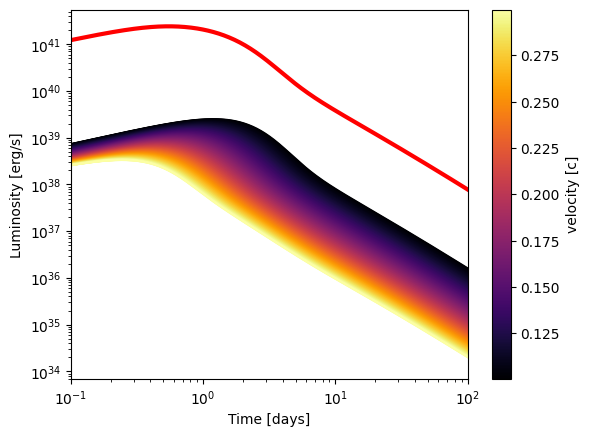

In [ ]:
# Normalize the v values to [0, 1] for the colormap
norm = plt.Normalize(min(vc/C_CONST), max(vc/C_CONST))

# Choose the colormap (e.g., 'inferno')
cmap = plt.cm.inferno

for index, v in enumerate(vc):
    color = cmap(norm(v/C_CONST))  # Get color based on v
    plt.loglog(t/tday, lum_v_matrix[index], color = color)

plt.semilogy(t/tday, Ltot, color = 'red', linewidth = '3')

# Add a colorbar to indicate the v values

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array for the colorbar
plt.colorbar(sm, label='velocity [c]')
plt.axvline(1/tday, linestyle = '--')
plt.axvline(900/tday, linestyle = '--')
plt.xlim(0.1, 100)

plt.xlabel('Time [days]')
plt.ylabel('Luminosity [erg/s]')


In [ ]:
# Find the photosphere

R_phot = np.zeros(len(t))
kv = opacity(Ye)


for index, time in enumerate(t):

    R_phot[index] = photosphere(time, R0, vc, dMv, kv)

# Calculate the effective temperature

T_eff = (Ltot/(4*np.pi*SB_CONST*R_phot**2))**(1./4.)

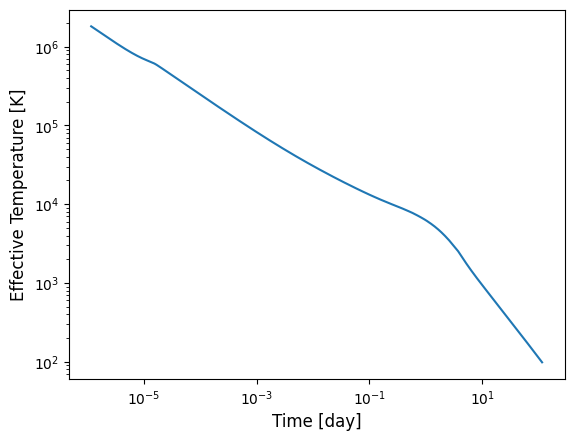

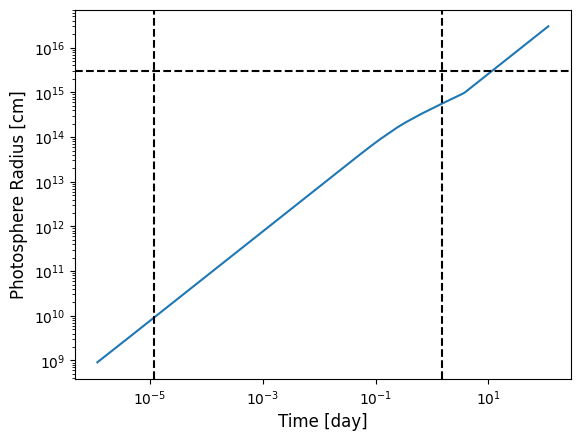

In [ ]:
plt.loglog(t/tday, T_eff)
plt.ylabel('Effective Temperature [K]', fontsize = 12)
plt.xlabel('Time [day]', fontsize = 12)
plt.show()

plt.loglog(t/tday, R_phot)
plt.axvline(tpeak, color = 'k', linestyle = '--' )
plt.axhline(3.e15, color = 'k', linestyle = '--' )
plt.axvline(1/tday, color = 'k', linestyle = '--' )

plt.ylabel('Photosphere Radius [cm]', fontsize = 12)
plt.xlabel('Time [day]', fontsize = 12)
plt.show()

In [ ]:
# Calculate the flux


F_U = Spec_Flux(nu_U, t, T_eff, R_phot, D)
F_B = Spec_Flux(nu_B, t, T_eff, R_phot, D)
F_V = Spec_Flux(nu_V, t, T_eff, R_phot, D)
F_R = Spec_Flux(nu_R, t, T_eff, R_phot, D)
F_K = Spec_Flux(nu_K, t, T_eff, R_phot, D)


mab_U = FromSpecFlux_to_ABmagntitude(F_U)
mab_B = FromSpecFlux_to_ABmagntitude(F_B)
mab_V = FromSpecFlux_to_ABmagntitude(F_V)
mab_R = FromSpecFlux_to_ABmagntitude(F_R)
mab_K = FromSpecFlux_to_ABmagntitude(F_K)

Text(0, 0.5, '$4\\pi D^2 \\nu F_\\nu \\, [erg/s]$')

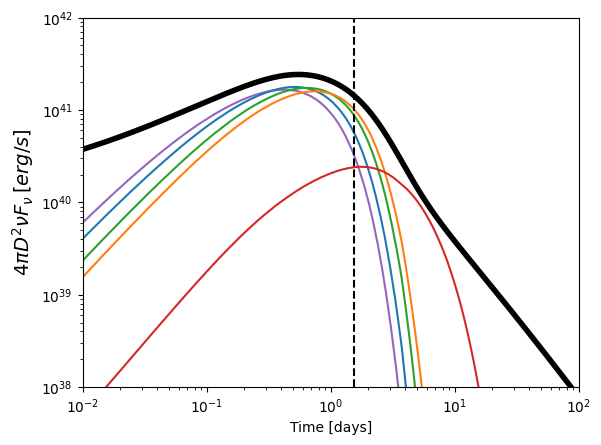

In [ ]:
plt.loglog(t/tday, (4*np.pi*D**2)*F_U*nu_U, color = 'C4')
plt.loglog(t/tday, (4*np.pi*D**2)*F_B*nu_B, color = 'C0')
plt.loglog(t/tday, (4*np.pi*D**2)*F_V*nu_V, color = 'C2')
plt.loglog(t/tday, (4*np.pi*D**2)*F_R*nu_R, color = 'C1')
plt.loglog(t/tday, (4*np.pi*D**2)*F_K*nu_K, color = 'C3')


plt.loglog(t/tday, Ltot, color = 'k', linewidth =4)
plt.xlim(1.e-2, 1.e2)
plt.ylim(1.e38, 1.e42)
plt.axvline(tpeak, color = 'k', linestyle = 'dashed')
plt.xlabel('Time [days]')
plt.ylabel(r'$4\pi D^2 \nu F_\nu \, [erg/s]$', fontsize = 14)

Text(0, 0.5, 'AB Magnitude')

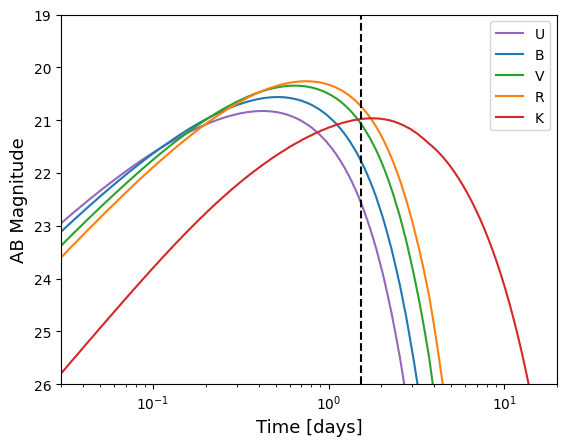

In [ ]:
plt.semilogx(t/tday, mab_U, color = 'C4', label = 'U')
plt.semilogx(t/tday, mab_B, color = 'C0', label = 'B')
plt.semilogx(t/tday, mab_V, color = 'C2', label = 'V')
plt.semilogx(t/tday, mab_R, color = 'C1', label = 'R')
plt.semilogx(t/tday, mab_K, color = 'C3', label = 'K')


#plt.loglog(t/tday, Ltot, color = 'k', linewidth =4)
plt.xlim(3.e-2, 2.e1)
plt.ylim(19, 26)
#plt.ylim(24, 30)
plt.axvline(tpeak, color = 'k', linestyle = 'dashed')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Time [days]', fontsize = 13)
plt.ylabel('AB Magnitude', fontsize = 13)

# Sandbox